In [1]:
import matplotlib.pyplot as plt
from preprocessing import get_ml_data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
city = 2304400
ini_date = None
end_train_date = None
end_date = None
predict_n = 4
look_back = 4
ratio = 0.75

filename = f'../../data_cluster/dengue_{city}_cluster.csv'

### Capturando os dados: 

In [3]:

X_data, X_train, targets, target = get_ml_data(city, ini_date = ini_date, end_train_date = end_train_date, end_date = end_date, 
                                        ratio = ratio , predict_n = predict_n, look_back = look_back, filename = filename)


In [8]:
import pandas as pd
df = pd.read_csv(filename, index_col = 'Unnamed: 0')

df[[f'casos_{city}']].head(15)

,casos_2304400
2010-01-03,56
2010-01-10,55
2010-01-17,77
2010-01-24,56
2010-01-31,114
2010-02-07,45
2010-02-14,81
2010-02-21,56
2010-02-28,105
2010-03-07,61


In [7]:
targets[4]

2010-02-07     61.0
2010-02-14     73.0
2010-02-21     84.0
2010-02-28    101.0
2010-03-07     89.0
              ...  
2023-05-28    230.0
2023-06-04    236.0
2023-06-11    232.0
2023-06-18    127.0
2023-06-25     20.0
Name: casos_2304400, Length: 698, dtype: float64

In [9]:
X_data[4:]

,casos_2307650_lag1,casos_2307650_lag2,casos_2307650_lag3,casos_2307650_lag4,p_rt1_2307650_lag1,p_rt1_2307650_lag2,p_rt1_2307650_lag3,p_rt1_2307650_lag4,p_inc100k_2307650_lag1,p_inc100k_2307650_lag2,...,diff_casos_2311702_lag3,diff_casos_2311702_lag4,diff_casos_2304509_lag1,diff_casos_2304509_lag2,diff_casos_2304509_lag3,diff_casos_2304509_lag4,diff_casos_2303709_lag1,diff_casos_2303709_lag2,diff_casos_2303709_lag3,diff_casos_2303709_lag4
2010-03-07,10.0,7.0,3.0,3.0,0.936622,0.850602,0.318756,0.269954,4.358096,3.050667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,0.0
2010-03-14,6.0,10.0,7.0,3.0,0.447883,0.936622,0.850602,0.318756,2.614858,4.358096,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,1.0
2010-03-21,6.0,6.0,10.0,7.0,0.323757,0.447883,0.936622,0.850602,2.614858,2.614858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0
2010-03-28,4.0,6.0,6.0,10.0,0.180907,0.323757,0.447883,0.936622,1.743238,2.614858,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,-1.0,1.0
2010-04-04,2.0,4.0,6.0,6.0,0.083204,0.180907,0.323757,0.447883,0.871619,1.743238,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,2.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-25,20.0,24.0,14.0,31.0,0.414482,0.435914,0.014407,0.568082,8.716192,10.459431,...,-4.0,5.0,0.0,-1.0,1.0,0.0,2.0,1.0,0.0,-4.0
2023-07-02,13.0,20.0,24.0,14.0,0.100477,0.414482,0.435914,0.014407,5.665525,8.716192,...,1.0,-4.0,0.0,0.0,-1.0,1.0,-2.0,2.0,1.0,0.0
2023-07-09,29.0,13.0,20.0,24.0,0.918983,0.100477,0.414482,0.435914,12.638478,5.665525,...,-1.0,1.0,0.0,0.0,0.0,-1.0,-3.0,-2.0,2.0,1.0
2023-07-16,3.0,29.0,13.0,20.0,0.000143,0.918983,0.100477,0.414482,1.307429,12.638478,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-3.0,-2.0,2.0


In [5]:
X_data.shape

(702, 448)

In [6]:
X_train.shape

(526, 448)

In [7]:
d = 4 # o alvo é o número de casos na semana daqui a 4 semanas
y_train = targets[d][:len(X_train)]

len(y_train)

526

In [8]:
y_data = targets[d]

len(y_data)

698

### Criando um modelo ML simples (random forest):

In [9]:
model = Pipeline([('scaling', StandardScaler()),
#                 ('feature_selection', SelectFromModel(RandomForestRegressor())),
                ('regression', RandomForestRegressor())])
model.fit(X_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('regression', RandomForestRegressor())])

In [10]:
pred = model.predict(X_data[:len(targets[d])].values)

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [11]:
len(target[d:].index)

698

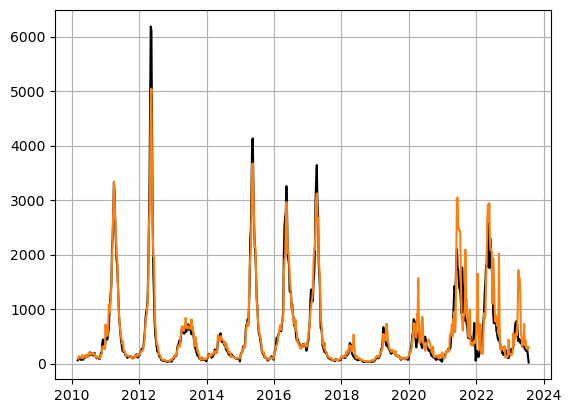

In [12]:
fig, ax = plt.subplots()

ax.plot(target[d:], label = 'Data', color = 'black')

ax.plot(target[d:].index, pred, label = 'Model', color = 'tab:orange')
ax.grid()

plt.show()

### Usando conformal regresor to predict the confidence interval: 

In [13]:
from crepes import ConformalRegressor, ConformalPredictiveSystem

from crepes.extras import hinge, margin, binning, DifficultyEstimator

In [14]:
model2 =  RandomForestRegressor(oob_score=True) 

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)

model2.fit(X_prop_train, y_prop_train)

RandomForestRegressor(oob_score=True)

In [15]:
# create a conformal regression instance 
cr_std = ConformalRegressor()

In [16]:
display(cr_std)

ConformalRegressor(fitted=False)

In [17]:
y_hat_cal = model2.predict(X_cal)

residuals_cal = y_cal - y_hat_cal

cr_std.fit(residuals_cal)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [18]:
X_test = X_data[X_train.shape[0]:len(y_data)]
y_test = y_data[X_train.shape[0]:]


In [19]:
X_test.shape

(172, 448)

In [20]:
y_test.shape

(172,)

In [21]:
y_hat_test = model2.predict(X_test)

intervals = cr_std.predict(y_hat_test, confidence=0.95, y_min = 0)

display(intervals)

array([[ 210.64, 2277.36],
       [   0.  , 1886.91],
       [   0.  , 1411.07],
       [   0.  , 1415.11],
       [   0.  , 1557.79],
       [   0.  , 1570.43],
       [   0.  , 1979.42],
       [   0.  , 1772.73],
       [   0.  , 1545.88],
       [   0.  , 1357.19],
       [   0.  , 1320.44],
       [   0.  , 1334.89],
       [   0.  , 1332.03],
       [   0.  , 1406.91],
       [   0.  , 1377.36],
       [   0.  , 1440.6 ],
       [   0.  , 1506.08],
       [   0.  , 1432.25],
       [   0.  , 1380.29],
       [   0.  , 1373.08],
       [   0.  , 1298.31],
       [   0.  , 1233.02],
       [   0.  , 1206.45],
       [   0.  , 1280.69],
       [   0.  , 1165.2 ],
       [   0.  , 1149.32],
       [   0.  , 1148.51],
       [   0.  , 1135.18],
       [   0.  , 1137.11],
       [   0.  , 1140.16],
       [   0.  , 1136.43],
       [   0.  , 1130.34],
       [   0.  , 1122.86],
       [   0.  , 1155.19],
       [   0.  , 1133.56],
       [   0.  , 1154.27],
       [   0.  , 1167.3 ],
 

In [22]:
intervals.shape

(172, 2)

In [23]:
intervals[:, 0].shape

(172,)

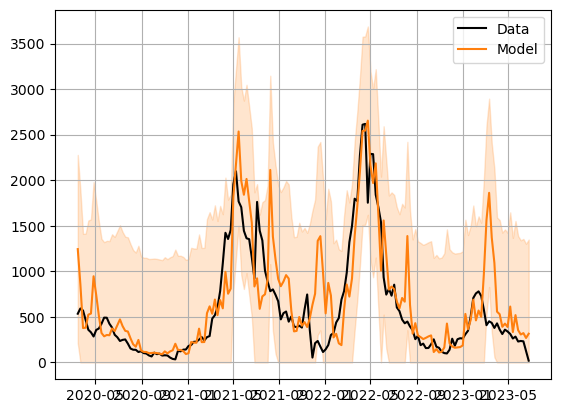

In [24]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals[:,0], intervals[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

In [25]:
%%time
de_knn = DifficultyEstimator()

de_knn.fit(X=X_prop_train, scaler=True)

display(de_knn)

sigmas_cal_knn_dist = de_knn.apply(X_cal)

cr_norm_knn_dist = ConformalRegressor()

cr_norm_knn_dist.fit(residuals_cal, sigmas=sigmas_cal_knn_dist)

display(cr_norm_knn_dist)

DifficultyEstimator(fitted=True, type=knn, k=25, target=none, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

CPU times: user 141 ms, sys: 17.8 ms, total: 159 ms
Wall time: 61.1 ms


In [26]:
sigmas_test_knn_dist = de_knn.apply(X_test)

intervals_norm_knn_dist = cr_norm_knn_dist.predict(y_hat_test, 
                                                   sigmas=sigmas_test_knn_dist,
                                                   y_min=0)

display(intervals_norm_knn_dist)

array([[ 445.42251912, 2042.57748088],
       [   0.        , 1796.12928559],
       [   0.        , 1303.08813912],
       [   0.        , 1286.60495446],
       [   0.        , 1510.74417625],
       [   0.        , 1523.45768992],
       [  89.47361558, 1802.64638442],
       [   0.        , 1798.85389775],
       [   0.        , 1789.79011364],
       [   0.        , 1682.62624751],
       [   0.        , 1646.33647246],
       [   0.        , 1443.3498908 ],
       [   0.        , 1418.88875055],
       [   0.        , 1495.83345654],
       [   0.        , 1525.78444066],
       [   0.        , 1808.56718038],
       [   0.        , 2057.15364883],
       [   0.        , 2003.72549567],
       [   0.        , 2218.69819139],
       [   0.        , 2311.35368126],
       [   0.        , 2147.05106435],
       [   0.        , 1937.90400292],
       [   0.        , 1673.30871757],
       [   0.        , 1737.44268329],
       [   0.        , 1440.68750509],
       [   0.        , 12

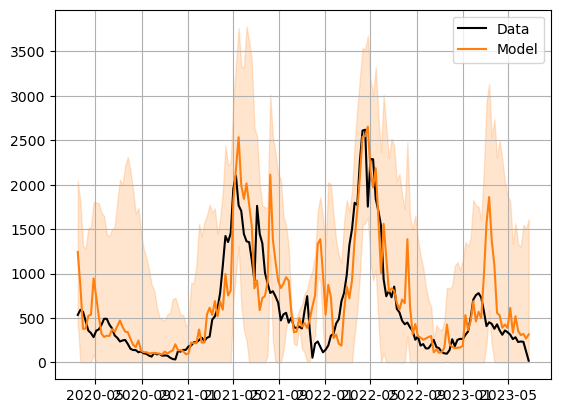

In [27]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals_norm_knn_dist[:,0], intervals_norm_knn_dist[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

In [28]:
de_knn_std = DifficultyEstimator()

de_knn_std.fit(X=X_prop_train, y=y_prop_train, scaler=True)

display(de_knn_std)

sigmas_cal_knn_std = de_knn_std.apply(X_cal)

cr_norm_knn_std = ConformalRegressor()

cr_norm_knn_std.fit(residuals_cal, sigmas=sigmas_cal_knn_std)

display(cr_norm_knn_std)

DifficultyEstimator(fitted=True, type=knn, k=25, target=labels, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [29]:
sigmas_test_knn_std = de_knn_std.apply(X_test)

intervals_norm_knn_std = cr_norm_knn_std.predict(y_hat_test, 
                                                 sigmas=sigmas_test_knn_std,
                                                 y_min=0)

display(intervals_norm_knn_std)

array([[0.00000000e+00, 5.06497990e+03],
       [4.80629928e+02, 1.22647007e+03],
       [0.00000000e+00, 7.60718927e+02],
       [1.60546471e+01, 7.47445353e+02],
       [1.28883265e+02, 9.19976735e+02],
       [0.00000000e+00, 1.70166128e+03],
       [0.00000000e+00, 2.49326457e+03],
       [0.00000000e+00, 3.63452636e+03],
       [1.47975052e+02, 8.77064948e+02],
       [0.00000000e+00, 6.94939916e+02],
       [0.00000000e+00, 1.34322925e+03],
       [0.00000000e+00, 6.77251495e+02],
       [0.00000000e+00, 6.42625216e+02],
       [2.33382423e+01, 7.23761758e+02],
       [6.88708005e+00, 6.81112920e+02],
       [0.00000000e+00, 3.19994687e+03],
       [0.00000000e+00, 2.23610479e+03],
       [0.00000000e+00, 3.52209988e+03],
       [0.00000000e+00, 3.57579366e+03],
       [0.00000000e+00, 1.79503029e+03],
       [1.68573197e+02, 3.61326803e+02],
       [1.27175751e+02, 2.72144249e+02],
       [5.52942867e+01, 2.90885713e+02],
       [1.02733360e+02, 3.91926640e+02],
       [3.490350

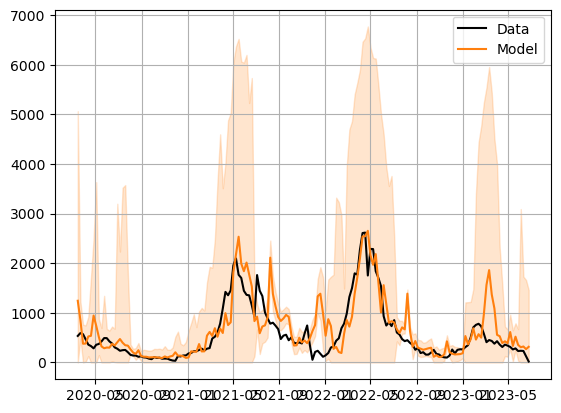

In [30]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals_norm_knn_std[:,0], intervals_norm_knn_std[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

In [31]:
oob_predictions = model2.oob_prediction_

residuals_oob = y_prop_train - oob_predictions

de_knn_res = DifficultyEstimator()

de_knn_res.fit(X=X_prop_train, residuals=residuals_oob, scaler=True)

display(de_knn_res)

sigmas_cal_knn_res = de_knn_res.apply(X_cal)

cr_norm_knn_res = ConformalRegressor()

cr_norm_knn_res.fit(residuals_cal, sigmas=sigmas_cal_knn_res)

display(cr_norm_knn_res)

DifficultyEstimator(fitted=True, type=knn, k=25, target=residuals, scaler=True, beta=0.01, oob=False)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [32]:
sigmas_test_knn_res = de_knn_res.apply(X_test)

intervals_norm_knn_res = cr_norm_knn_res.predict(y_hat_test, 
                                                 sigmas=sigmas_test_knn_res,
                                                 y_min=0)

display(intervals_norm_knn_res)

array([[   0.        , 3837.96926007],
       [   0.        , 1956.86702556],
       [   0.        , 1299.70199253],
       [   0.        , 1061.22544561],
       [   0.        , 1373.28146628],
       [   0.        , 1751.44157389],
       [   0.        , 2391.26631321],
       [   0.        , 2938.74040901],
       [   0.        , 1522.28256815],
       [   0.        ,  814.13729779],
       [   0.        ,  868.56469991],
       [   0.        , 1028.94371166],
       [   0.        , 1112.72318597],
       [   0.        , 1113.06902567],
       [   0.        ,  977.05261675],
       [   0.        , 1790.04241614],
       [   0.        , 1238.9509859 ],
       [   0.        , 1698.90811776],
       [   0.        , 1787.53946702],
       [   0.        ,  837.06882344],
       [  81.92216033,  447.97783967],
       [  14.78752031,  384.53247969],
       [   0.        ,  481.97166862],
       [   0.        ,  538.80698226],
       [  34.97007844,  228.70992156],
       [  41.91574925,  1

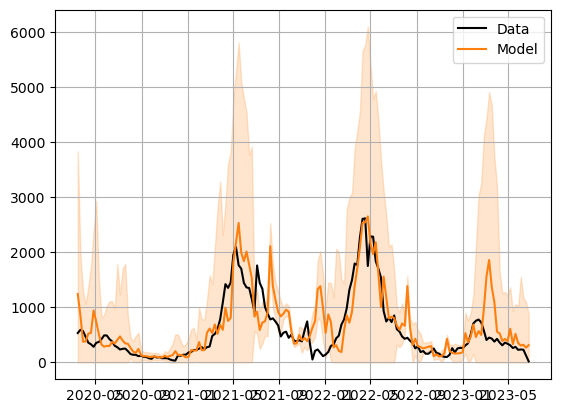

In [33]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals_norm_knn_res[:,0], intervals_norm_knn_res[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

In [34]:
de_var = DifficultyEstimator()

de_var.fit(X=X_prop_train, learner=model2, scaler=True)

display(de_var)

sigmas_cal_var = de_var.apply(X_cal)

cr_norm_var = ConformalRegressor()

cr_norm_var.fit(residuals_cal, sigmas=sigmas_cal_var)

display(cr_norm_var)

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature nam

DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature nam

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [35]:
sigmas_test_var = de_var.apply(X_test)

intervals_norm_var = cr_norm_var.predict(y_hat_test, 
                                         sigmas=sigmas_test_var, 
                                         y_min=0)

display(intervals_norm_var)

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature nam

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature nam

array([[0.00000000e+00, 5.61063712e+03],
       [0.00000000e+00, 3.66507529e+03],
       [1.57770399e+02, 5.97649601e+02],
       [1.11109194e+00, 7.62388908e+02],
       [0.00000000e+00, 1.31906786e+03],
       [2.30771512e+01, 1.05106285e+03],
       [0.00000000e+00, 3.81044011e+03],
       [0.00000000e+00, 1.78567019e+03],
       [0.00000000e+00, 1.90607093e+03],
       [1.63405424e+02, 4.84254576e+02],
       [1.15785645e+02, 4.58374355e+02],
       [1.26340522e+02, 4.76719478e+02],
       [1.44108434e+02, 4.53231566e+02],
       [0.00000000e+00, 1.41563790e+03],
       [8.87962144e+01, 5.99203786e+02],
       [1.68760088e+02, 6.45719912e+02],
       [0.00000000e+00, 1.74391436e+03],
       [9.16055728e+01, 7.06174427e+02],
       [1.17845652e+02, 5.76014348e+02],
       [8.08378057e+01, 5.98602194e+02],
       [6.05812653e+01, 4.69318735e+02],
       [3.88336487e+01, 3.60486351e+02],
       [5.41025659e+01, 2.92077434e+02],
       [1.84519911e+01, 4.76208009e+02],
       [1.348167

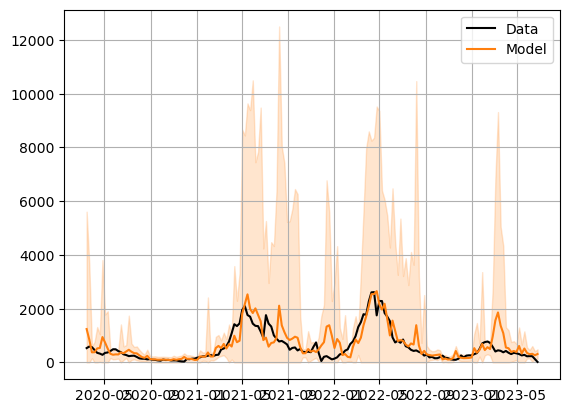

In [36]:
fig, ax = plt.subplots()

ax.plot(y_test, label = 'Data', color = 'black')

ax.plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax.fill_between(y_test.index, intervals_norm_var[:,0], intervals_norm_var[:,1], color = 'tab:orange', alpha = 0.2)

ax.grid()

ax.legend()

plt.show()

Mondrial conformal regressor (não funcionou para esse caso)

bins_cal, bin_thresholds = binning(sigmas_cal_var, bins=20)

cr_mond = ConformalRegressor()

cr_mond.fit(residuals_cal, bins=bins_cal)

display(cr_mond)


bins_test = binning(sigmas_test_var, bins=bin_thresholds)

intervals_mond = cr_mond.predict(y_hat_test, bins=bins_test, y_min=0)

display(intervals_mond)

### Investigating the prediction intervals
Let us first put all the intervals in a dictionary.



In [37]:
prediction_intervals = {
    "Std CR":intervals,
    "Norm CR knn dist":intervals_norm_knn_dist,
    "Norm CR knn std":intervals_norm_knn_std,
    "Norm CR knn res":intervals_norm_knn_res,
    "Norm CR var":intervals_norm_var,
}


In [38]:
import numpy as np 
import pandas as pd 
coverages = []
mean_sizes = []
median_sizes = []

for name in prediction_intervals.keys():
    intervals = prediction_intervals[name]
    coverages.append(np.sum([1 if (y_test[i]>=intervals[i,0] and 
                                   y_test[i]<=intervals[i,1]) else 0 
                            for i in range(len(y_test))])/len(y_test))
    mean_sizes.append((intervals[:,1]-intervals[:,0]).mean())
    median_sizes.append(np.median((intervals[:,1]-intervals[:,0])))

pred_int_df = pd.DataFrame({"Coverage":coverages, 
                            "Mean size":mean_sizes, 
                            "Median size":median_sizes}, 
                           index=list(prediction_intervals.keys()))

pred_int_df.loc["Mean"] = [pred_int_df["Coverage"].mean(), 
                           pred_int_df["Mean size"].mean(),
                           pred_int_df["Median size"].mean()]

display(pred_int_df.round(4))

,Coverage,Mean size,Median size
Std CR,0.9709,1583.6094,1539.7450
Norm CR knn dist,0.9419,1566.8308,1611.9397
Norm CR knn std,0.8663,1935.5335,753.2795
Norm CR knn res,0.8430,1546.0069,920.7803
Norm CR var,0.9302,2542.8628,938.3770
Mean,0.9105,1834.9687,1152.8243


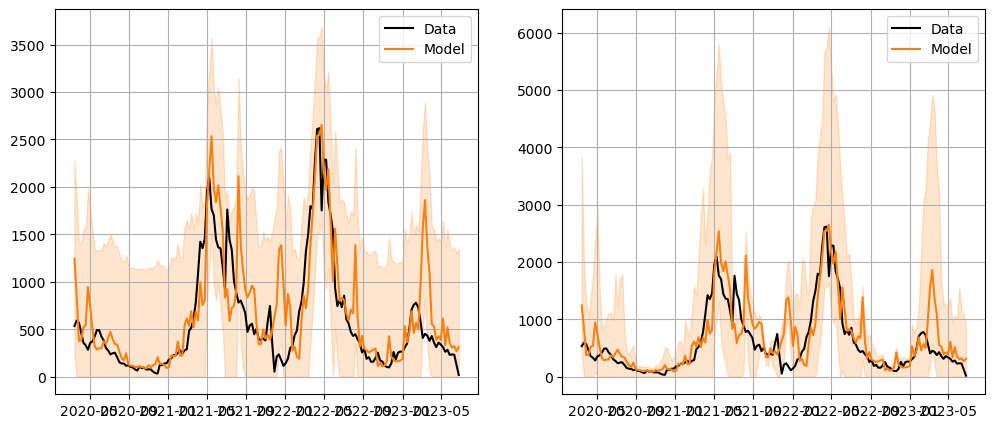

In [43]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))

ax[0].plot(y_test, label = 'Data', color = 'black')

ax[0].plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax[0].fill_between(y_test.index, prediction_intervals['Std CR'][:,0],  prediction_intervals['Std CR'][:,1], color = 'tab:orange', alpha = 0.2)

ax[0].grid()

ax[0].legend()

ax[1].plot(y_test, label = 'Data', color = 'black')

ax[1].plot(y_test.index, y_hat_test, label = 'Model', color = 'tab:orange')

ax[1].fill_between(y_test.index, prediction_intervals['Norm CR knn dist'][:,0],  prediction_intervals['Norm CR knn res'][:,1], color = 'tab:orange', alpha = 0.2)

ax[1].grid()

ax[1].legend()


plt.show()
